In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Functions that will be used for postprocessing
class apce_data_struct:
    def __init__(self, t, ds_t, icemass, h2omass, numparts):
        self.t = t
        self.ds_t = ds_t
        self.icemass = icemass
        self.h2omass = h2omass
        self.numparts = numparts
    
def read_apcemm_data(directory):
    t_mins = []
    ds_t = []
    ice_mass = []
    total_h2o_mass = []
    num_particles = []

    for file in sorted(os.listdir(directory)):
        if(file.startswith('ts_aerosol') and file.endswith('.nc')):
            file_path = os.path.join(directory,file)
            ds = xr.open_dataset(file_path, engine = "netcdf4", decode_times = False)
            ds_t.append(ds)
            tokens = file_path.split('.')
            mins = int(tokens[-2][-2:])
            hrs = int(tokens[-2][-4:-2])
            t_mins.append(hrs*60 + mins)

            ice_mass.append(ds["Ice Mass"])
            num_particles.append(ds["Number Ice Particles"])
            dx = abs(ds["x"][-1] - ds["x"][0])/len(ds["x"])
            dy = abs(ds["y"][-1] - ds["y"][0])/len(ds["y"])
            
            h2o_mass = np.sum(ds["H2O"]) * 1e6 / 6.022e23 * 0.018 * dx*dy + ds["Ice Mass"]
            total_h2o_mass.append(h2o_mass.values)
            
    return apce_data_struct(t_mins, ds_t, ice_mass, total_h2o_mass, num_particles)

def removeLow(arr, cutoff = 1e-3):
    func = lambda x: (x > cutoff) * x
    vfunc = np.vectorize(func)
    return vfunc(arr)

In [3]:
apce_data = read_apcemm_data('APCEMM_out/')
t = apce_data.t
ds_t = apce_data.ds_t
ice_mass = apce_data.icemass
total_h2o_mass = apce_data.h2omass

In [4]:
ds_t_1h = ds_t[6]

#print(ds_t_1h)

# Assume we are splitting the data 47 times over the x values since the x width is divisible by 47

samples = 47

indices = []
values = []
IWCs = []
Eff_rads = []
xs = []

# Generate the indices and IWC values for the places the domain is split
for i in range(0, samples):
    index = i * int(len(ds_t_1h['x'])/samples)
    indices.append(index)
    values.append(np.float32(ds_t_1h['x'][index].values))

for i in range(0,len(indices)-1):
    IWCs.append(ds_t_1h['IWC'][:, indices[i]:indices[i+1]+1:1])
    Eff_rads.append(ds_t_1h['Effective radius'][:, indices[i]:indices[i+1]+1:1])
    xs.append(ds_t_1h["x"][indices[i]:indices[i+1]+1:1])

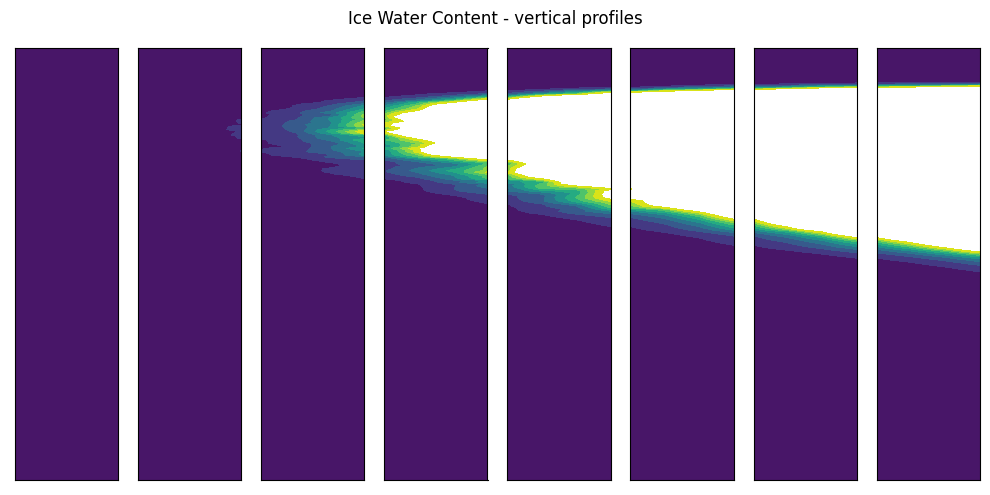

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize = (10,5))
fig.suptitle("Ice Water Content - vertical profiles")

ds_t_1h = ds_t[6]

levels = np.linspace(0, IWCs[2].max(), 10)

X_map1h, Y_map1h = np.meshgrid(xs[0], ds_t_1h["y"])
map1h = axes[0].contourf(X_map1h, Y_map1h, IWCs[0], levels=levels)

X_map2h, Y_map2h = np.meshgrid(xs[1], ds_t_1h["y"])
map2h = axes[1].contourf(X_map2h, Y_map2h, IWCs[1], levels=levels)

X_map3h, Y_map3h = np.meshgrid(xs[2], ds_t_1h["y"])
map3h = axes[2].contourf(X_map3h, Y_map3h, IWCs[2], levels=levels)

X_map4h, Y_map4h = np.meshgrid(xs[3], ds_t_1h["y"])
map4h = axes[3].contourf(X_map4h, Y_map4h, IWCs[3], levels=levels)

X_map5h, Y_map5h = np.meshgrid(xs[4], ds_t_1h["y"])
map1h = axes[4].contourf(X_map1h, Y_map1h, IWCs[4], levels=levels)

X_map6h, Y_map6h = np.meshgrid(xs[5], ds_t_1h["y"])
map2h = axes[5].contourf(X_map2h, Y_map2h, IWCs[5], levels=levels)

X_map7h, Y_map7h = np.meshgrid(xs[6], ds_t_1h["y"])
map3h = axes[6].contourf(X_map3h, Y_map3h, IWCs[6], levels=levels)

X_map8h, Y_map8h = np.meshgrid(xs[7], ds_t_1h["y"])
map4h = axes[7].contourf(X_map4h, Y_map4h, IWCs[7], levels=levels)

axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[5].get_yaxis().set_visible(False)
axes[6].get_yaxis().set_visible(False)
axes[7].get_yaxis().set_visible(False)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)
axes[5].get_xaxis().set_visible(False)
axes[6].get_xaxis().set_visible(False)
axes[7].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
IWCs_avg = []
Eff_rads_avg = []

for i in range(0, len(IWCs)):
    temp1 = []
    for j in IWCs[i]:
        temp1.append((j.values).mean())
    IWCs_avg.append(temp1)

for i in range(0, len(Eff_rads)):
    temp2 = []
    for j in Eff_rads[i]:
        temp2.append((j.values).mean())
    Eff_rads_avg.append(temp2)

In [7]:
ys = ds_t_1h["y"].values

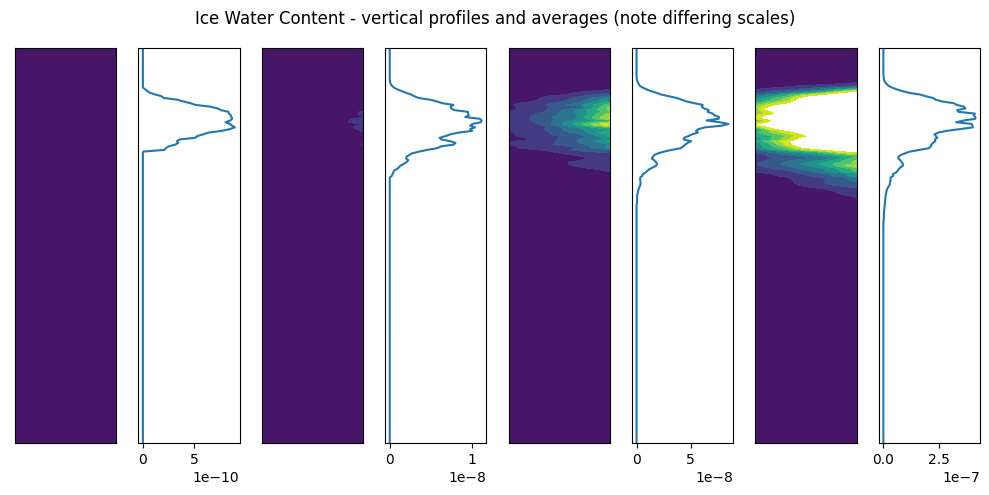

In [8]:
levels = np.linspace(0, IWCs[2].max(), 10)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize = (10,5))
fig.suptitle("Ice Water Content - vertical profiles and averages (note differing scales)")

X_map1h, Y_map1h = np.meshgrid(xs[0].values, ys)
map1h = axes[0].contourf(X_map1h, Y_map1h, IWCs[0], levels=levels)
axes[0].set_ylim(-1400,200)

axes[1].plot(IWCs_avg[0], ys)
axes[1].set_ylim(-1400,200)

X_map1h, Y_map1h = np.meshgrid(xs[1].values, ys)
map1h = axes[2].contourf(X_map1h, Y_map1h, IWCs[1], levels=levels)
axes[2].set_ylim(-1400,200)

axes[3].plot(IWCs_avg[1], ys)
axes[3].set_ylim(-1400,200)

X_map1h, Y_map1h = np.meshgrid(xs[2].values, ys)
map1h = axes[4].contourf(X_map1h, Y_map1h, IWCs[2], levels=levels)
axes[4].set_ylim(-1400,200)

axes[5].plot(IWCs_avg[2], ys)
axes[5].set_ylim(-1400,200)

X_map1h, Y_map1h = np.meshgrid(xs[3].values, ys)
map1h = axes[6].contourf(X_map1h, Y_map1h, IWCs[3], levels=levels)
axes[6].set_ylim(-1400,200)

axes[7].plot(IWCs_avg[3], ys)
axes[7].set_ylim(-1400,200)

axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[5].get_yaxis().set_visible(False)
axes[6].get_yaxis().set_visible(False)
axes[7].get_yaxis().set_visible(False)

axes[0].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)
axes[6].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()


In [9]:
base_altitude = 10000
altitude = ys+base_altitude

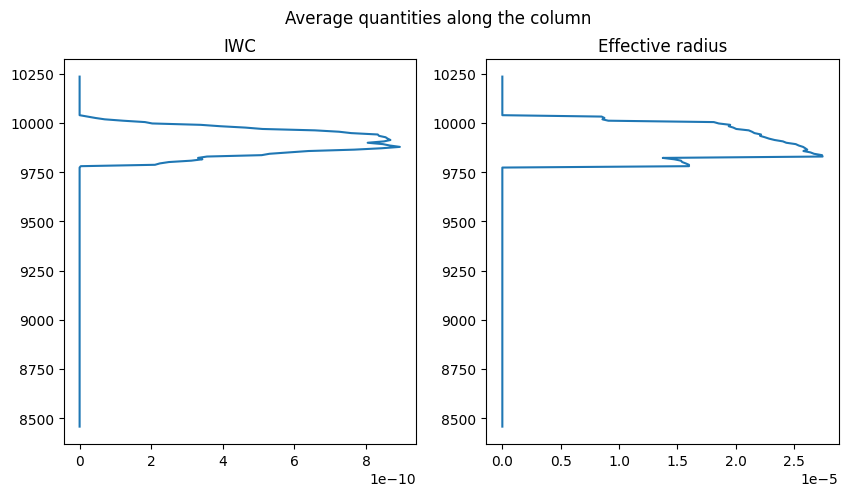

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

fig.suptitle("Average quantities along the column")

axes[0].plot(IWCs_avg[0], altitude)
axes[0].set_title("IWC")
axes[1].plot(Eff_rads_avg[0], altitude)
axes[1].set_title("Effective radius")

fig.show()

In [11]:
altitude = altitude / 1000
altitude_temp = [0, min(altitude)-1/1000]
altitude = np.concatenate((altitude_temp, altitude))

temp10 = [0,0]

Eff_rads_temp_avg = []
IWCs_temp_avg = []

for i in range(0, len(xs)):
    Eff_rads_temp_avg.append(np.concatenate((temp10, Eff_rads_avg[i])) * 10 ** 6)
    IWCs_temp_avg.append(np.concatenate((temp10, IWCs_avg[i]))*1000)

In [12]:
try: 
    os.makedirs("clouds")
except:
    print("Directory already exists")

for i in range(0,len(xs)):

    file_name = (f"./clouds/cloud{i}.DAT")

    with open(file_name, "w") as f:
        f.write("#      z         IWC          R_eff\n")
        f.write("#     (km)     (g/m^3)         (um)\n")

        for j in range(0,len(altitude)):
            f.write(f"     {altitude[j]:.3f}   {IWCs_temp_avg[i][j]:.9f}   {Eff_rads_temp_avg[i][j]:.9f}\n")


Directory already exists


In [13]:
atmosphere_file_path = "../data/atmmod/afglus.dat"
solar_source_path = "../data/solar_flux_atlas_plus_modtran"
ic_file_path = "../examples/IC.DAT"
ic_properties_path = "../examples/IC.001.mie"
day_of_year = 170
albedo = 0.2
sza = 32
number_of_streams = 6

In [14]:
with open("test.INP", "w") as f:
    f.write(f"atmosphere_file {atmosphere_file_path}\n")
    f.write(f"source solar {solar_source_path}\n")
    f.write("mol_modify O3 300. DU\n")
    f.write("\n")
    f.write(f"day_of_year {day_of_year:.0f}\n")
    f.write(f"albedo {albedo:.2f}\n")
    f.write(f"sza {sza:.2f}\n")
    f.write(f"number_of_streams {number_of_streams}\n")
    f.write("\n")
    f.write("rte_solver disort\n")
    f.write("disort_intcor moments\n")
    f.write("mol_abs_param Kato\n")
    f.write("wavelength_index 1 32\n")
    f.write("\n")
    f.write(f"ic_file 1D {ic_file_path}\n")
    f.write(f"ic_properties {ic_properties_path}\n")
    f.write("\n")
    f.write("quiet")